# Análise de Sentimentos
## Aluno: João Pedro Regazzi Ferreira da Silva
## DRE: 120030115

In [1]:
# Priemiramente, importo o language_v1 do google
from google.cloud import language_v1

In [2]:
# Autentico meu ambiente para utilizar o google sentiment
import os
credential_path = r"C:\Users\jpreg\Desktop\Agenda-Guia\2021.1\Trabalhos 2021.1\IA\double-venture-327120-254466fb561c.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
client = language_v1.LanguageServiceClient()

In [3]:
# Importo a biblioteca do twitter e defino minhas chaves de autenticação
import tweepy
auth_file = []
with open('tt_tokens.txt') as file:
    for line in file:
        auth_file.append(line.replace('\n', ''))

In [4]:
consumer_key, consumer_secret, access_token, access_token_secret = auth_file

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [5]:
# Construo funções para limpar os tweets
import numpy as np
import re
def list_tweets(user_id, count, prt=False):
    tweets = api.user_timeline("@" + user_id, count=count, tweet_mode='extended')
    tw = []
    for t in tweets:
        tw.append(t.full_text)
        if prt:
            print(t.full_text)
            print()
    return tw

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(lst):
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    lst = np.vectorize(remove_pattern)(lst, "#[\w]*")
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")
    return lst

In [6]:
# Utilizando a API do twitter, obtenho 500 tweets de cada conta de interesse
lacta_tweets = clean_tweets(list_tweets("Lacta",200))
ufrj_tweets = clean_tweets(list_tweets("ufrj",200))

In [7]:
# Analiso os tweets da Lacta, guardando a pontuação de cada tweet em uma lista
lista_sentimentos = []
for tweet in lacta_tweets:
    document = language_v1.Document(content=tweet, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
    if sentiment.score >= 0.1:
        lista_sentimentos.append(1)
    elif sentiment.score <= -0.1:
        lista_sentimentos.append(-1)
    else:
        lista_sentimentos.append(0)
print(lista_sentimentos[:20])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [8]:
# Analiso os tweets da UFRJ, de forma análoga aos da Lacta
sentimentos_lacta = lista_sentimentos
sentimentos_ufrj = []
for tweet in ufrj_tweets:
    document = language_v1.Document(content=tweet, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
    if sentiment.score >= 0.1:
        sentimentos_ufrj.append(1)
    elif sentiment.score <= -0.1:
        sentimentos_ufrj.append(-1)
    else:
        sentimentos_ufrj.append(0)
print(sentimentos_ufrj[:20])

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


In [6]:
# Importo a biblioteca para construir as word clouds
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [7]:
def word_cloud(wd_list, cor):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap=cor,
        max_words=50,
        min_word_length=3,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

## 1) Resultados da análise de tweets da Lacta:

### 1.1) WordCloud:

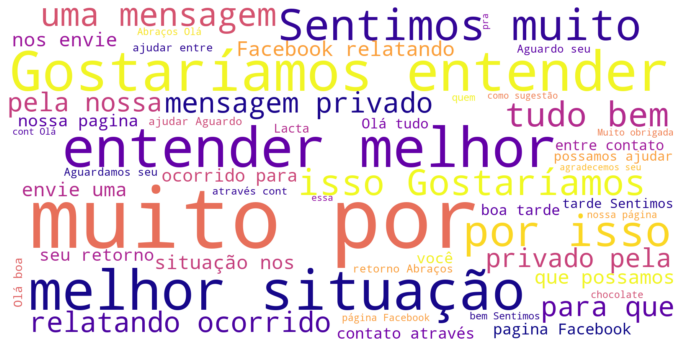

In [37]:
word_cloud(lacta_tweets, 'plasma')

### 1.2) Gráfico de barras:

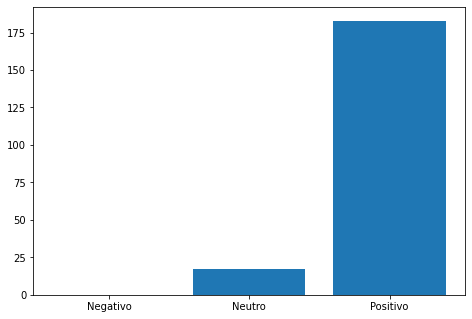

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentimentos = ['Negativo', 'Neutro', 'Positivo']
contagem_lacta = [sentimentos_lacta.count(-1),sentimentos_lacta.count(0),sentimentos_lacta.count(1)]
ax.bar(sentimentos,contagem_lacta)
plt.show()

## 2) Resultados da análise de tweets da UFRJ:

### 2.1) Word Cloud:

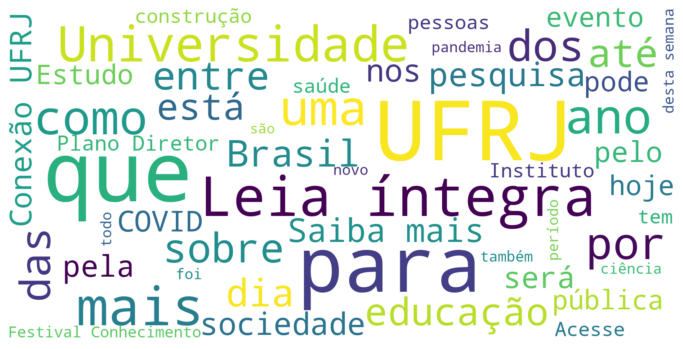

In [39]:
word_cloud(ufrj_tweets, 'viridis')

### 2.2) Gráfico de barras:

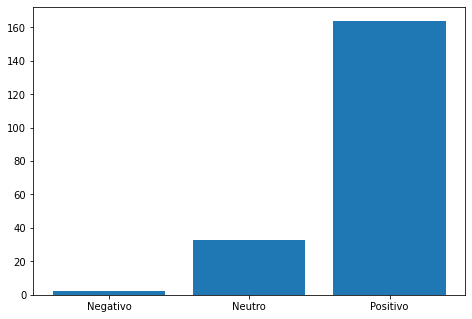

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentimentos = ['Negativo', 'Neutro', 'Positivo']
contagem_ufrj = [sentimentos_ufrj.count(-1),sentimentos_ufrj.count(0),sentimentos_ufrj.count(1)]
ax.bar(sentimentos, contagem_ufrj)
plt.show()

In [13]:
def list_tweets_keyword(query, count):
    tw = []
    tweets = api.search(query, count=count)
    for t in tweets:
        tw.append(t.text)
    return tw

# Testando Bonoro

In [11]:
bolsonaro_tweets = []

In [9]:
def milQueries(l_tweets, palavra):
    intermediario = []
    for i in range(10):
        intermediario = clean_tweets(list_tweets_keyword(palavra,100))
        l_tweets.extend(intermediario)

In [23]:
# Sempre que roda obtem 1k tweets com a palavra selecionada
milQueries(bolsonaro_tweets, "bolsonaro")

In [24]:
# Para deletar tweets repetidos
bolsonaro_tweets = list(set(bolsonaro_tweets))

In [25]:
# Ver a quantidade de tweets
len(bolsonaro_tweets)

200

In [26]:
sent_bonoro = []
def analisarTweets(l_tweets, i=0, j=10):
    for tweet in bolsonaro_tweets[i:j]:
        document = language_v1.Document(content=tweet, type_=language_v1.Document.Type.PLAIN_TEXT)
        sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
        sent_bonoro.append(round(sentiment.score, 1))

In [27]:
analisarTweets(bolsonaro_tweets, 0, len(bolsonaro_tweets))

In [79]:
print(sent_bonoro)

[0.4, -0.1, -0.5, -0.2, -0.3, -0.1, 0.0, 0.2, -0.1, 0.1, -0.1, 0.2, 0.0, -0.3, -0.1, 0.0, -0.4, 0.0, 0.4, -0.6, 0.0, -0.1, -0.2, -0.5, 0.8, 0.1, 0.1, -0.1, 0.1, -0.2, 0.0, 0.2, 0.2, 0.3, -0.1, 0.0, -0.2, 0.0, 0.1, -0.3, 0.1, 0.1, 0.1, 0.1, 0.3, -0.2, -0.3, 0.1, 0.1, -0.2, 0.3, 0.2, -0.3, -0.1, 0.6, 0.3, -0.3, 0.1, 0.5, 0.3, -0.4, 0.4, 0.0, 0.5, 0.1, 0.5, 0.4, 0.3, 0.1, -0.1, 0.3, 0.1, -0.6, 0.3, 0.0, 0.5, 0.3, -0.4, -0.3, 0.0, 0.4, -0.3, -0.5, 0.0, 0.0, 0.3, -0.6, 0.2, 0.7, -0.1, 0.0, -0.1, 0.1, 0.2, 0.0, 0.0, 0.0, 0.0, -0.5, 0.2, 0.0, -0.1, -0.1, -0.2, 0.0, -0.2, 0.0, -0.3, 0.0, 0.7, -0.2, -0.5, -0.4, 0.4, 0.4, 0.1, 0.0, 0.0, 0.0, 0.0, -0.4, 0.0, -0.3, 0.2, -0.1, 0.2, 0.2, -0.1, 0.0, 0.3, 0.3, 0.3, 0.4, -0.2, 0.0, -0.8, 0.2, 0.0, 0.0, 0.7, 0.0, -0.1, 0.0, -0.4, 0.1, 0.0, 0.0, 0.0, -0.2, 0.0, 0.3, 0.2, 0.2, -0.3, 0.0, 0.2, 0.0, 0.0, 0.4, -0.4, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, -0.1, -0.1, -0.1, -0.2, -0.3, 0.2, 0.2, 0.0, -0.4, 0.0, -0.1, 0.4, 0.1, 0.0, 0.1, -0.2, -0.2, 0.0, 0.1, 

In [81]:
# Para ver os indexes de tweets com certo score, para poderem ser analizados
index = []
for i, num in enumerate(sent_bonoro):
    if num >= 0.5:
        index.append(i)
print(index)

[24, 54, 58, 63, 65, 75, 88, 109, 139, 163]


In [82]:
# Para ler um tweet e ver seu score
i = 109
print(bolsonaro_tweets[i] + f" \n Score: {sent_bonoro[i]}" )

 A 3 via tem formato de falo, vibra e servirá para introduzir na bunda de repórteres ansiosos com a vitória de Bolsonaro. 
 Score: 0.7


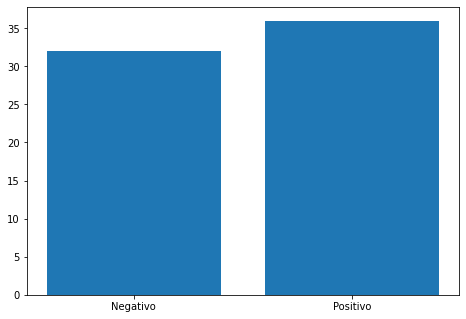

In [48]:
neg, posi = 0, 0
for num in sent_bonoro:
    if num >= 0.3:
        posi += 1
    elif num <= -0.3:
        neg += 1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentimentos = ['Negativo', 'Positivo']
contagem_bonoro = [neg, posi]
ax.bar(sentimentos, contagem_bonoro)
plt.show()

In [49]:
import seaborn as sea
def plot_hist(scores, title):
    sea.kdeplot(scores, fill=True)
    plt.title(title)
    plt.show()

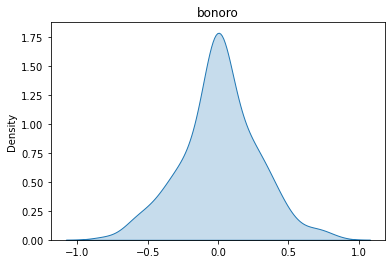

In [50]:
plot_hist(sent_bonoro, 'bonoro')

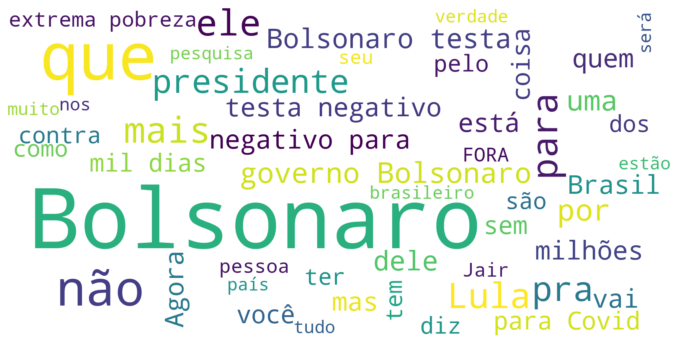

In [83]:
word_cloud(bolsonaro_tweets, 'viridis')

# Testando lula

In [84]:
lula_tweets = []

In [85]:
# Sempre que roda obtem 1k tweets com a palavra selecionada
milQueries(lula_tweets, "Lula")

In [86]:
# Para deletar tweets repetidos
lula_tweets = list(set(lula_tweets))

In [87]:
# Ver a quantidade de tweets
print(len(lula_tweets))
sent_lula = []

91


In [88]:
def analisarLula(l_tweets, i=0, j=10):
    for tweet in lula_tweets[i:j]:
        document = language_v1.Document(content=tweet, type_=language_v1.Document.Type.PLAIN_TEXT)
        sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
        sent_lula.append(round(sentiment.score, 1))

In [89]:
analisarLula(lula_tweets, 0, len(lula_tweets))

In [90]:
print(sent_lula)

[0.1, 0.1, 0.3, 0.0, 0.1, 0.0, 0.1, -0.3, 0.0, 0.0, 0.4, -0.1, 0.1, 0.9, 0.1, -0.5, 0.3, 0.0, 0.1, -0.3, 0.1, 0.3, 0.0, 0.3, 0.0, 0.2, 0.0, -0.3, 0.0, -0.1, 0.3, -0.2, 0.1, 0.3, -0.5, -0.3, -0.1, -0.3, 0.1, 0.2, -0.3, 0.2, 0.1, -0.3, -0.3, -0.4, 0.1, 0.9, -0.4, 0.3, -0.3, -0.4, 0.6, -0.5, 0.0, 0.0, -0.4, 0.6, 0.5, -0.2, 0.0, 0.5, -0.1, 0.0, 0.0, -0.3, 0.1, 0.6, 0.2, 0.1, 0.0, 0.1, 0.3, -0.3, 0.0, 0.6, 0.3, 0.4, 0.2, -0.4, -0.4, -0.2, 0.0, 0.2, 0.1, 0.1, 0.0, 0.2, -0.3, -0.3, 0.0]


In [98]:
# Para ver os indexes de tweets com certo score, para poderem ser analizados
index = []
for i, num in enumerate(sent_lula):
    if num == 0.5:
        index.append(i)
print(index)

[58, 61]


In [100]:
# Para ler um tweet e ver seu score
i = 61
print(lula_tweets[i] + f" \n Score: {sent_lula[i]}" )

  Propiedad de Lula couffaine 😌 
 Score: 0.5


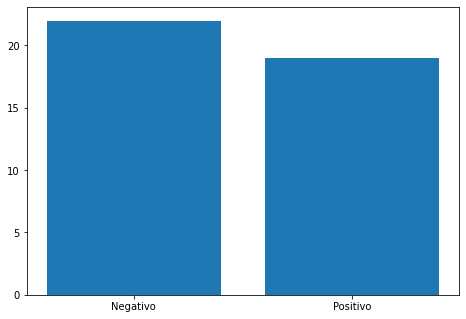

In [101]:
neg, posi = 0, 0
for num in sent_lula:
    if num >= 0.3:
        posi += 1
    elif num <= -0.3:
        neg += 1
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentimentos = ['Negativo', 'Positivo']
contagem_bonoro = [neg, posi]
ax.bar(sentimentos, contagem_bonoro)
plt.show()

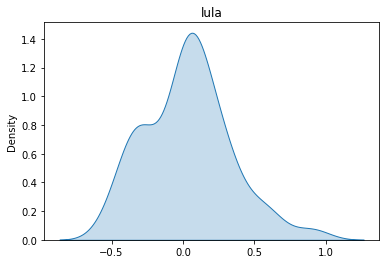

In [102]:
plot_hist(sent_lula, 'lula')

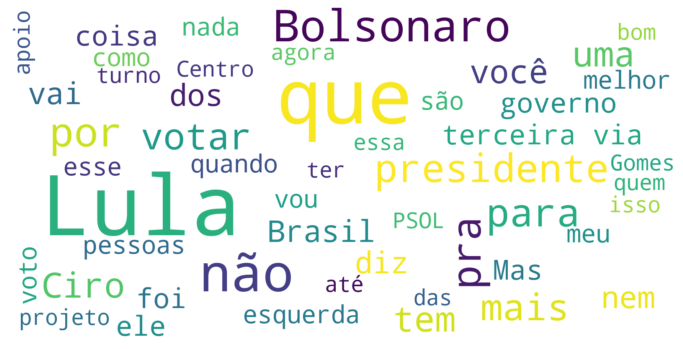

In [103]:
word_cloud(lula_tweets, 'viridis')